In [37]:
# For importing utils
import sys
sys.path.append("..")

In [38]:
from utils import PERTURBATIONS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [39]:
def plot_datasets(ax, datasets, seeds, data_path, layer, checkpoints, nps):

    for dataset in datasets:
        # Filter the data for the layer and available checkpoints
        all_seeds_layer_data = []
        for s in seeds:
            df = pd.read_csv(data_path.format(dataset["data"], nps, s))
            layer_data = df[df['GPT-2 Layer'] == layer][[f'Accuracy (ckpt {cp})' for cp in checkpoints]].T
            layer_data.columns = [dataset['label']]
            all_seeds_layer_data.append(list(layer_data[dataset['label']]))
        
        all_seeds_layer_data = np.array(all_seeds_layer_data) * 100.0
        means = np.mean(all_seeds_layer_data, axis=0)

        ci = None
        if len(seeds) > 1:
            sems = stats.sem(all_seeds_layer_data, axis=0)
            # Calculate confidence interval using t-distribution
            ci_lower, ci_upper = stats.t.interval(0.95, df=len(seeds)-1,
                                                  loc=means, scale=sems)
            ci = (ci_upper - ci_lower) / 2

        # Plotting the data for the layer
        ax.errorbar(checkpoints, means, ci, marker=dataset['marker'], linestyle=dataset['linestyle'],
                    color=PERTURBATIONS[dataset['data']]['color'], label=dataset['label'])

## Plot Accuracy by Averaging Last 4 Layers

In [40]:
def plot_accuracy(rev_datasets, hop_datasets, checkpoints, seeds, pos_encodings=True):

    # Setting up the plot with all subplots in a single row
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=False)
    # fig.subplots_adjust(wspace=0)
    fig.supxlabel("Training Steps", y=-0.01)

    if pos_encodings:
        nps = ""
    else:
        nps = "_no_pos_encodings"

    data_path = "edge_probing_results/{}_100M{}/randinit_mean_pooling_seed{}.csv"

    # Plotting the data
    axes[0].set_ylabel("Probe Accuracy", fontsize=12)

    # Plot *Reverse
    plot_datasets(axes[0], rev_datasets, seeds, data_path, "Avg Last 4", checkpoints, nps)
    axes[0].set_title("*Reverse")
    axes[0].grid(True)
    axes[0].legend(loc='lower right', framealpha=1)

    # Plot *Hop
    plot_datasets(axes[1], hop_datasets, seeds, data_path, "Avg Last 4", checkpoints, nps)
    axes[1].set_title("*Hop")
    axes[1].grid(True)
    axes[1].legend(loc='lower right', framealpha=1)

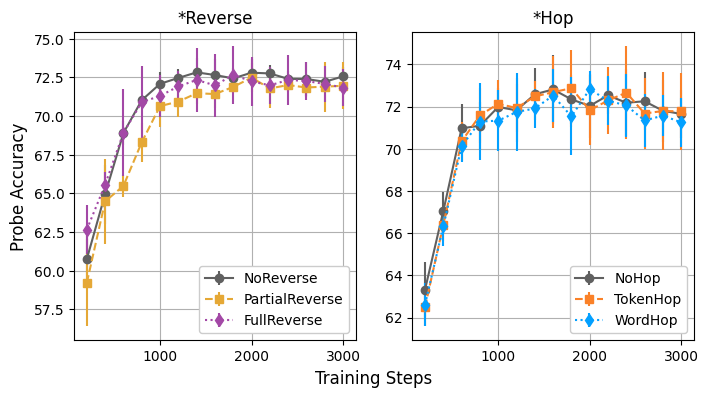

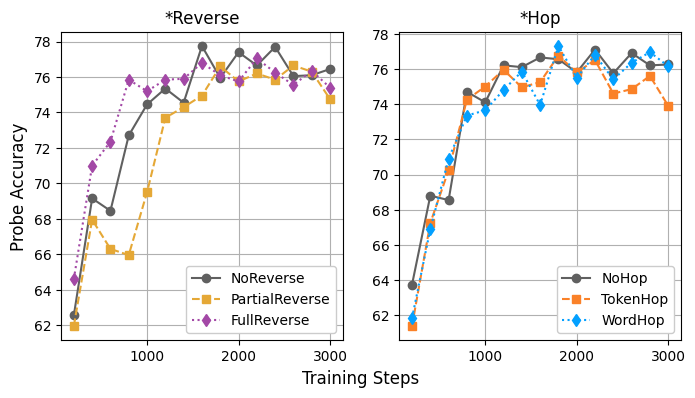

In [41]:
CHECKPOINTS = list(range(200, 3000+1, 200))
SEEDS = [0, 14, 41, 53, 96]

# Define the input files, layers, and checkpoints
rev_files = [
    {'data': 'reverse_control',
     'label': 'NoReverse',
     'linestyle': '-',
     'marker': 'o',
    },
    {'data': 'reverse_partial',
     'label': 'PartialReverse',
     'linestyle': '--',
     'marker': 's',
    },
    {'data': 'reverse_full',
     'label': 'FullReverse',
     'linestyle': ':',
     'marker': 'd',
    },
]
hop_files = [
    {'data': 'hop_control',
     'label': 'NoHop',
     'linestyle': '-',
     'marker': 'o',
    },
    {'data': 'hop_tokens4',
     'label': 'TokenHop',
     'linestyle': '--',
     'marker': 's',
    },
    {'data': 'hop_words4',
     'label': 'WordHop',
     'linestyle': ':',
     'marker': 'd',
    },
]

# Generate the plot
plot_accuracy(rev_files, hop_files, CHECKPOINTS, SEEDS)
plt.savefig("figures/probing.pdf", format="pdf", bbox_inches="tight")

# No Pos Encodings
plot_accuracy(rev_files, hop_files, CHECKPOINTS, [53], pos_encodings=False)
plt.savefig("figures/probing_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")

## Plot Accuracy with Individual Layers

In [42]:
def plot_accuracy_layer(datasets, layers, checkpoints, seeds, pos_encodings=True):

    # Setting up the plot with all subplots in a single row
    fig, axes = plt.subplots(nrows=1, ncols=len(layers), figsize=(4 * len(layers), 4), sharey=True)
    fig.subplots_adjust(wspace=0)
    fig.supxlabel("Training Steps", y=-0.01)
    if len(layers) == 1:
        axes = [axes]

    if pos_encodings:
        nps = ""
    else:
        nps = "_no_pos_encodings"

    data_path = "edge_probing_results/{}_100M{}/randinit_mean_pooling_seed{}.csv"

    # Plotting the data
    for i, layer in enumerate(layers):
        ax = axes[i]
        if i == 0:
            ax.set_ylabel("Probe Accuracy", fontsize=12)

        # Main plotting function
        plot_datasets(ax, datasets, seeds, data_path, layer, checkpoints, nps)

        # Setting plot details
        ax.set_title(f'Layer {layer}')
        ax.grid(True)

        if i != 0:
            for tick in ax.yaxis.get_major_ticks():
                tick.tick1line.set_visible(False)
                tick.tick2line.set_visible(False)
        
        if i == len(layers) - 1:
            ax.legend(loc='lower right', framealpha=1)

In [43]:
LAYERS = [str(l) for l in [1, 3, 6, 9, 12]]
CHECKPOINTS = list(range(200, 3000+1, 200))

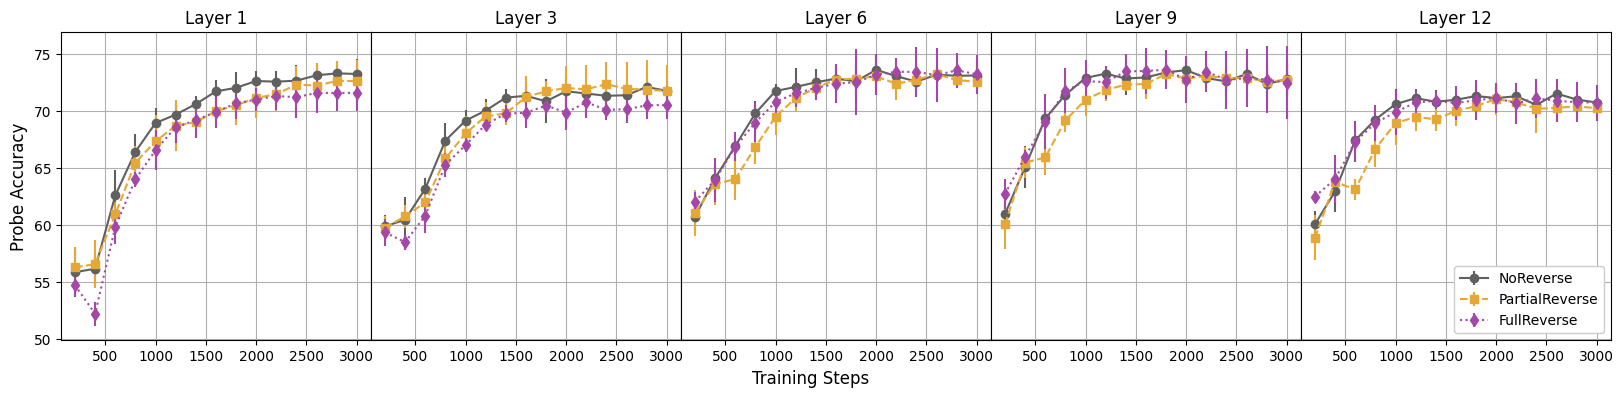

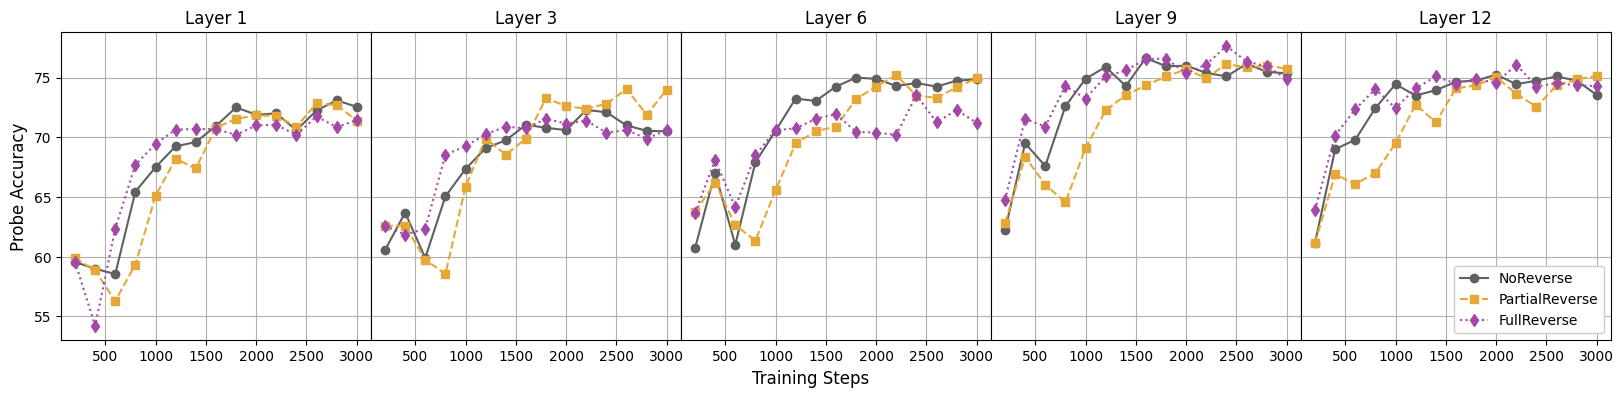

In [44]:
# Define the input files, layers, and checkpoints
data_files = [
    {'data': 'reverse_control',
     'label': 'NoReverse',
     'linestyle': '-',
     'marker': 'o',
    },
    {'data': 'reverse_partial',
     'label': 'PartialReverse',
     'linestyle': '--',
     'marker': 's',
    },
    {'data': 'reverse_full',
     'label': 'FullReverse',
     'linestyle': ':',
     'marker': 'd',
    },
]

# Generate the plot
plot_accuracy_layer(data_files, LAYERS, CHECKPOINTS, SEEDS)
plt.savefig("figures/probing_layers_reverse.pdf", format="pdf", bbox_inches="tight")

# No Pos Encodings
plot_accuracy_layer(data_files, LAYERS, CHECKPOINTS, [53], pos_encodings=False)
plt.savefig("figures/probing_layers_reverse_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")

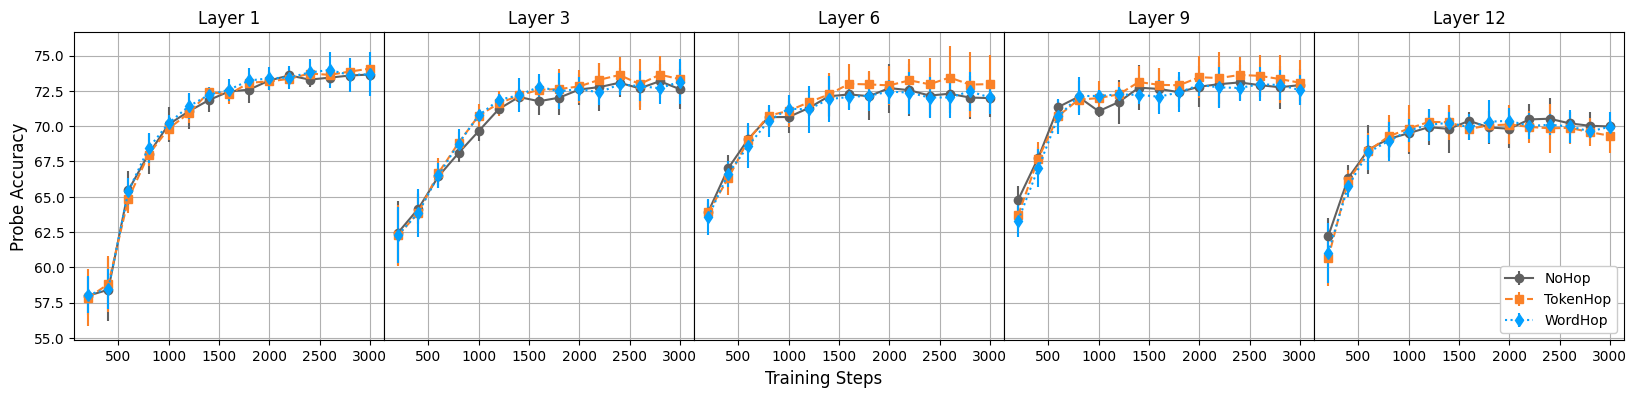

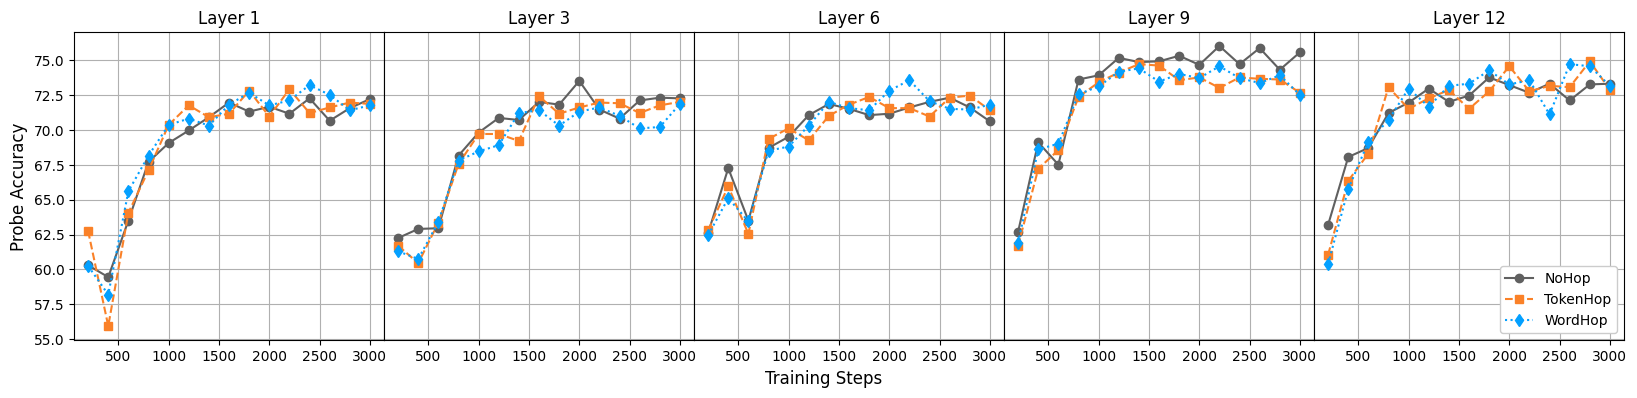

In [45]:
# Define the input files, layers, and checkpoints
data_files = [
    {'data': 'hop_control',
     'label': 'NoHop',
     'linestyle': '-',
     'marker': 'o',
    },
    {'data': 'hop_tokens4',
     'label': 'TokenHop',
     'linestyle': '--',
     'marker': 's',
    },
    {'data': 'hop_words4',
     'label': 'WordHop',
     'linestyle': ':',
     'marker': 'd',
    },
]

# Generate the plot
plot_accuracy_layer(data_files, LAYERS, CHECKPOINTS, SEEDS)
plt.savefig("figures/probing_layers_hop.pdf", format="pdf", bbox_inches="tight")

# No Pos Encodings
plot_accuracy_layer(data_files, LAYERS, CHECKPOINTS, [53], pos_encodings=False)
plt.savefig("figures/probing_layers_hop_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")